# Brain Tumor Detection
## Resnet101 - Classifier + Regressor
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/brain-tumor-detection'

In [2]:
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt

2025-03-14 13:50:23.553170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741960223.561531  318131 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741960223.564036  318131 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741960223.574049  318131 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741960223.574064  318131 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741960223.574065  318131 computation_placer.cc:177] computation placer alr

In [3]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [4]:
from src.data_handler.data_loader import DataLoader
from src.data_handler.annotation_processor import AnnotationProcessor
from src.data_handler.preprocessor import Preprocessor

In [5]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [6]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/-Brain-Tumor-Detection-2/train/


In [7]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [8]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)


IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
LOG_DIR = cfg.OUTPUTS.LOG_DIR
CHECK_POINT_DIR = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}

NUM_EPOCHS = cfg.TRAIN.NUM_EPOCHS
LEARNING_RATE = cfg.TRAIN.LEARNING_RATE

NUM_CLASSES = len(CLASS_NAME)

## Dataset Download from Roboflow

In [9]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow(api_key="AAjLIN3PenSZ29LjbI3d")
    project = rf.workspace("yousef-ghanem-jzj4y").project("brain-tumor-detection-fpf1f")
    version = project.version(2)
    dataset = version.download("tensorflow") 

## Load images from directory

In [10]:
prepare_train_dataset = AnnotationProcessor(annotation_file= str(TRAIN_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
train_images, train_class_ids, train_bboxes  = prepare_train_dataset.process_annotations(image_dir=TRAIN_DIR, class_id_map=_class_map)

len(train_images), len(train_class_ids), len(train_bboxes)

(6851, 6851, 6851)

In [11]:
train_bboxes[0]

array([[0.68345324, 0.54545455, 0.95683453, 0.76515152],
       [0.42446043, 0.48484848, 0.99280576, 0.96969697],
       [0.46043165, 0.53030303, 0.99280576, 0.78030303]])

In [12]:
train_class_ids

[[0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1],
 [2],
 [1],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [1],
 [0, 1],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2]

In [13]:
train_dl = DataLoader(train_images, train_class_ids, train_bboxes)
train_ds = train_dl.load_train_dataset()
train_ds = Preprocessor(train_ds).preprocess()
train_ds = train_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

I0000 00:00:1741960237.312774  318131 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7190 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [14]:
for batch in train_ds.take(1):
    image, (cls, bbx) = batch
    print(image.shape, cls.shape, bbx.shape)
    print(cls[5])
    print(image[1].numpy().min(), image[1].numpy().max())
    for c in cls:
        print(c.numpy())

(32, 240, 240, 3) (32, 3) (32, 3, 4)
tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32)
-123.68 88.52914
[0. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]


2025-03-14 13:50:44.113272: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Validation datasets setup

In [15]:
prepare_valid_dataset = AnnotationProcessor(annotation_file= str(VALIDATION_DIR/'_annotations.csv'))

valid_image_paths, valid_class_ids, valid_bboxes  = prepare_valid_dataset.process_annotations(image_dir=VALIDATION_DIR, class_id_map=_class_map)
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

(1963, 1963, 1963)

In [16]:
valid_dl = DataLoader(valid_image_paths, valid_class_ids, valid_bboxes).load_val_dataset()
valid_ds = Preprocessor(valid_dl).preprocess()
valid_ds = valid_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [17]:
for batch in valid_ds.take(1):
    image, (cls, bbx) = batch
    print(image.shape, cls.shape, bbx.shape)
    print(image[1].numpy().min(), image[1].numpy().max())

(32, 240, 240, 3) (32, 3) (32, 3, 4)
-123.68 138.49847


2025-03-14 13:50:45.505312: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training Setup

## Define loss

In [18]:
padded_class_ids = train_dl.multi_hot_class_ids
padded_class_ids[:10]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [0., 1., 0.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 0.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [19]:
from src.losses import binary_weighted_loss as _loss

positive_weights, negative_weights = _loss.compute_class_weights(padded_class_ids)
positive_weights, negative_weights 

(array([0.38140417, 0.01547219, 0.40767771]),
 array([0.61859584, 0.9845278 , 0.5923223 ], dtype=float32))

## Define ResNet50 Model

### Final Model

In [20]:
CLS_METRICS = [
    tf.keras.metrics.AUC(name='AUC', multi_label=True), 
    tf.keras.metrics.F1Score(name='f1_score',average='weighted'),
]

REG_METRICS = [
    tf.keras.metrics.MeanAbsoluteError(name='MAE'),
    tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES, name='iou_score'),
]

### Define  Callbacks

In [21]:
import os

to_monitor = 'val_classification_AUC'
mode = 'max'
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, 
                                            patience=5, 
                                            monitor=to_monitor,
                                            mode=mode,
                                            min_lr=1e-7,
                                            verbose=1),

    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "classifier_ckpt_{epoch}.keras") ,
                                        save_weights_only=False,
                                        save_best_only=True,
                                        monitor=to_monitor,
                                        mode=mode,
                                        verbose=1),
                                        
    tf.keras.callbacks.EarlyStopping(monitor=to_monitor, 
                                    patience=10,
                                    mode=mode, 
                                    restore_best_weights=True,
                                    verbose=1),

]

### Define Optimizer

In [22]:
optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE)

## Model Building and Compilation

In [23]:
from src.models.resnet101 import final_model

tf.keras.backend.clear_session()

model = final_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

model.compile(
    optimizer=optimizer,
    loss={'classification': _loss.set_binary_crossentropy_weighted_loss(positive_weights, negative_weights),
          'bounding_box': tf.keras.losses.Huber()},
    metrics={'classification': CLS_METRICS, 'bounding_box': REG_METRICS})  # Use IoU metric


Total layers in ResNet101: 345
Unfreezing the last 172 layers (50% of total layers)


In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 246, 246,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 120, 120,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 120, 120,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 122, 122,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 60, 60,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 60, 60,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 60, 60,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 60, 60,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_3_c

 Total params: 45,288,847 (172.76 MB)

 Trainable params: 33,268,751 (126.91 MB)

 Non-trainable params: 12,020,096 (45.85 MB)

### Train and Validate the model

In [25]:
import mlflow

mlflow.set_experiment("/brain-tumor-resnet101-detector")
mlflow.tensorflow.autolog(log_models=True, 
                          log_datasets=False, 
                          log_input_examples=True,
                          keras_model_kwargs={"save_format": "keras"},
                          checkpoint_monitor=to_monitor, 
                          checkpoint_mode=mode)

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks],
)

2025/03/14 13:50:50 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.
2025/03/14 13:50:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7b47a9d6b8aa4bcfbec96d18506f1fa8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30


I0000 00:00:1741960278.388213  318390 service.cc:152] XLA service 0x7024140028d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741960278.388285  318390 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-14 13:51:19.235177: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741960282.620404  318390 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/215 ━━━━━━━━━━━━━━━━━━━━ 2:32:40 43s/step - bounding_box_MAE: 0.7472 - bounding_box_iou_score: 0.2941 - bounding_box_loss: 0.3977 - classification_AUC: 0.3304 - classification_f1_score: 0.4925 - classification_loss: 0.7012 - loss: 7.9650

I0000 00:00:1741960293.265233  318390 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - bounding_box_MAE: 0.3407 - bounding_box_iou_score: 0.3226 - bounding_box_loss: 0.0975 - classification_AUC: 0.6352 - classification_f1_score: 0.4951 - classification_loss: 0.6391 - loss: 6.5795
Epoch 1: val_classification_AUC improved from -inf to 0.75945, saving model to output/checkpoints/classifier_ckpt_1.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 94s 241ms/step - bounding_box_MAE: 0.3405 - bounding_box_iou_score: 0.3226 - bounding_box_loss: 0.0974 - classification_AUC: 0.6355 - classification_f1_score: 0.4953 - classification_loss: 0.6389 - loss: 6.5747 - val_bounding_box_MAE: 0.3212 - val_bounding_box_iou_score: 0.2848 - val_bounding_box_loss: 0.0840 - val_classification_AUC: 0.7594 - val_classification_f1_score: 0.3498 - val_classification_loss: 0.9712 - val_loss: 4.2242 - learning_rate: 1.0000e-04
Epoch 2/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - bounding_box_MAE: 0.2344 - bounding_box_iou_score: 0.3523 - bounding_box_loss: 0.0431 - classification_AUC: 0.7930 - classification_f1_score: 0.5642 - classification_loss: 0.4969 - loss: 3.1543
Epoch 2: val_classification_AUC improved from 0.75945 to 0.82813, saving model to output/checkpoints/classifier_ckpt_2.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - bounding_box_MAE: 0.2343 - bounding_box_iou_score: 0.3521 - bounding_box_loss: 0.0431 - classification_AUC: 0.7932 - classification_f1_score: 0.5643 - classification_loss: 0.4968 - loss: 3.1498 - val_bounding_box_MAE: 0.2073 - val_bounding_box_iou_score: 0.4999 - val_bounding_box_loss: 0.0364 - val_classification_AUC: 0.8281 - val_classification_f1_score: 0.5810 - val_classification_loss: 0.5198 - val_loss: 1.8979 - learning_rate: 1.0000e-04
Epoch 3/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - bounding_box_MAE: 0.2034 - bounding_box_iou_score: 0.4923 - bounding_box_loss: 0.0333 - classification_AUC: 0.8435 - classification_f1_score: 0.5774 - classification_loss: 0.4246 - loss: 1.5606
Epoch 3: val_classification_AUC improved from 0.82813 to 0.86582, saving model to output/checkpoints/classifier_ckpt_3.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - bounding_box_MAE: 0.2034 - bounding_box_iou_score: 0.4923 - bounding_box_loss: 0.0332 - classification_AUC: 0.8436 - classification_f1_score: 0.5775 - classification_loss: 0.4245 - loss: 1.5587 - val_bounding_box_MAE: 0.1764 - val_bounding_box_iou_score: 0.5173 - val_bounding_box_loss: 0.0252 - val_classification_AUC: 0.8658 - val_classification_f1_score: 0.5032 - val_classification_loss: 0.4335 - val_loss: 1.0332 - learning_rate: 1.0000e-04
Epoch 4/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - bounding_box_MAE: 0.1770 - bounding_box_iou_score: 0.4936 - bounding_box_loss: 0.0261 - classification_AUC: 0.8744 - classification_f1_score: 0.5933 - classification_loss: 0.3734 - loss: 0.8774
Epoch 4: val_classification_AUC did not improve from 0.86582
215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - bounding_box_MAE: 0.1770 - bounding_box_iou_score: 0.4936 - bounding_box_loss: 0.0261 - classification_AUC: 0.8744 - classification_f1_score: 0.5933 - 

215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - bounding_box_MAE: 0.1548 - bounding_box_iou_score: 0.4935 - bounding_box_loss: 0.0211 - classification_AUC: 0.8907 - classification_f1_score: 0.5973 - classification_loss: 0.3007 - loss: 0.4478 - val_bounding_box_MAE: 0.1644 - val_bounding_box_iou_score: 0.4986 - val_bounding_box_loss: 0.0234 - val_classification_AUC: 0.8667 - val_classification_f1_score: 0.5637 - val_classification_loss: 0.4019 - val_loss: 0.5144 - learning_rate: 1.0000e-04
Epoch 7/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - bounding_box_MAE: 0.1538 - bounding_box_iou_score: 0.4941 - bounding_box_loss: 0.0211 - classification_AUC: 0.9194 - classification_f1_score: 0.5967 - classification_loss: 0.2993 - loss: 0.4008
Epoch 7: val_classification_AUC did not improve from 0.86673
215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 129ms/step - bounding_box_MAE: 0.1538 - bounding_box_iou_score: 0.4941 - bounding_box_loss: 0.0211 - classification_AUC: 0.9194 - classification_f1_score: 0.5967 - 

215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - bounding_box_MAE: 0.1448 - bounding_box_iou_score: 0.4935 - bounding_box_loss: 0.0188 - classification_AUC: 0.9350 - classification_f1_score: 0.5968 - classification_loss: 0.2546 - loss: 0.3312 - val_bounding_box_MAE: 0.1469 - val_bounding_box_iou_score: 0.5006 - val_bounding_box_loss: 0.0213 - val_classification_AUC: 0.8811 - val_classification_f1_score: 0.5650 - val_classification_loss: 0.4019 - val_loss: 0.4723 - learning_rate: 1.0000e-04
Epoch 9/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - bounding_box_MAE: 0.1386 - bounding_box_iou_score: 0.4933 - bounding_box_loss: 0.0180 - classification_AUC: 0.9251 - classification_f1_score: 0.5989 - classification_loss: 0.2334 - loss: 0.2964
Epoch 9: val_classification_AUC did not improve from 0.88108
215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - bounding_box_MAE: 0.1385 - bounding_box_iou_score: 0.4933 - bounding_box_loss: 0.0180 - classification_AUC: 0.9252 - classification_f1_score: 0.5989 - 

215/215 ━━━━━━━━━━━━━━━━━━━━ 37s 142ms/step - bounding_box_MAE: 0.1327 - bounding_box_iou_score: 0.4948 - bounding_box_loss: 0.0165 - classification_AUC: 0.9489 - classification_f1_score: 0.5816 - classification_loss: 0.2014 - loss: 0.2471 - val_bounding_box_MAE: 0.1329 - val_bounding_box_iou_score: 0.4950 - val_bounding_box_loss: 0.0187 - val_classification_AUC: 0.9085 - val_classification_f1_score: 0.5939 - val_classification_loss: 0.3674 - val_loss: 0.4151 - learning_rate: 1.0000e-04
Epoch 13/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - bounding_box_MAE: 0.1289 - bounding_box_iou_score: 0.4935 - bounding_box_loss: 0.0153 - classification_AUC: 0.9659 - classification_f1_score: 0.6016 - classification_loss: 0.1584 - loss: 0.2008
Epoch 13: val_classification_AUC did not improve from 0.90853
215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 126ms/step - bounding_box_MAE: 0.1289 - bounding_box_iou_score: 0.4935 - bounding_box_loss: 0.0153 - classification_AUC: 0.9659 - classification_f1_score: 0.6016 

215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 138ms/step - bounding_box_MAE: 0.1267 - bounding_box_iou_score: 0.4937 - bounding_box_loss: 0.0150 - classification_AUC: 0.9690 - classification_f1_score: 0.6038 - classification_loss: 0.1478 - loss: 0.1850 - val_bounding_box_MAE: 0.1384 - val_bounding_box_iou_score: 0.3314 - val_bounding_box_loss: 0.0187 - val_classification_AUC: 0.9157 - val_classification_f1_score: 0.5631 - val_classification_loss: 0.3582 - val_loss: 0.4004 - learning_rate: 1.0000e-04
Epoch 18/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - bounding_box_MAE: 0.1224 - bounding_box_iou_score: 0.4925 - bounding_box_loss: 0.0141 - classification_AUC: 0.9823 - classification_f1_score: 0.6001 - classification_loss: 0.1140 - loss: 0.1493
Epoch 18: val_classification_AUC did not improve from 0.91574
215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - bounding_box_MAE: 0.1224 - bounding_box_iou_score: 0.4925 - bounding_box_loss: 0.0141 - classification_AUC: 0.9823 - classification_f1_score: 0.6002 

215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - bounding_box_MAE: 0.1277 - bounding_box_iou_score: 0.4948 - bounding_box_loss: 0.0152 - classification_AUC: 0.9851 - classification_f1_score: 0.5869 - classification_loss: 0.1275 - loss: 0.1633 - val_bounding_box_MAE: 0.1400 - val_bounding_box_iou_score: 0.4894 - val_bounding_box_loss: 0.0194 - val_classification_AUC: 0.9296 - val_classification_f1_score: 0.5567 - val_classification_loss: 0.4463 - val_loss: 0.4897 - learning_rate: 1.0000e-04
Epoch 21/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - bounding_box_MAE: 0.1190 - bounding_box_iou_score: 0.4953 - bounding_box_loss: 0.0133 - classification_AUC: 0.9896 - classification_f1_score: 0.6014 - classification_loss: 0.0963 - loss: 0.1297
Epoch 21: val_classification_AUC did not improve from 0.92963
215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - bounding_box_MAE: 0.1190 - bounding_box_iou_score: 0.4953 - bounding_box_loss: 0.0133 - classification_AUC: 0.9896 - classification_f1_score: 0.6014 

2025/03/14 14:09:20 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/03/14 14:09:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpnlp5c1ar/model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/14 14:09:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


## Model Evaluation

### Testing Datasets setup

In [26]:
import matplotlib.pyplot as plt

def visualize_training_results(history):
    """
    Visualizes training and validation loss, and training and validation accuracy.

    Args:
        history: A dictionary or object containing training history data.
                 For example, a Keras History object or a dictionary with keys:
                 'loss', 'val_loss', 'accuracy', 'val_accuracy'.
    """

    if isinstance(history, dict):
        # Assumes history is a dictionary
        loss = history.get('loss')
        val_loss = history.get('val_loss')
        accuracy = history.get('accuracy')
        val_accuracy = history.get('val_accuracy')
    else:
        # Assumes history is a Keras History object or similar
        loss = history.history.get('loss')
        val_loss = history.history.get('val_loss')
        accuracy = history.history.get('accuracy')
        val_accuracy = history.history.get('val_accuracy')

    if loss and val_loss:
        epochs = range(1, len(loss) + 1)

        plt.figure(figsize=(12, 5))

        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    if accuracy and val_accuracy:
        if not (loss and val_loss):
          plt.figure(figsize=(12, 5))
        else:
          plt.subplot(1, 2, 2)
        # Plot training & validation accuracy values
        plt.plot(epochs, accuracy, 'r', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout() #prevents overlapping titles/labels
    plt.show()


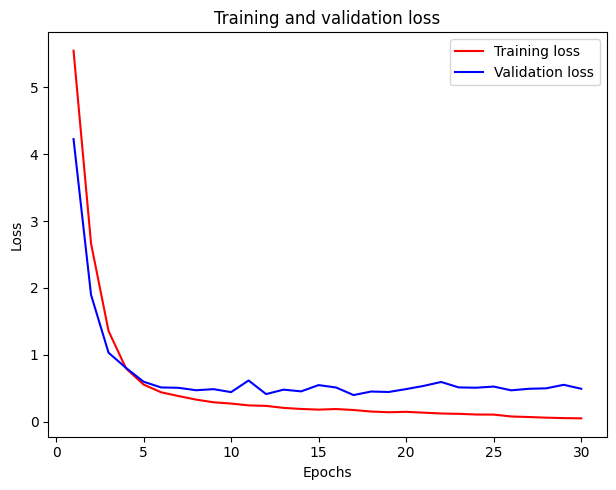

In [27]:
visualize_training_results(history.history)

In [28]:
prepare_test_dataset = AnnotationProcessor(annotation_file= str(TEST_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
test_image_paths, test_class_ids, test_bboxes = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, class_id_map=_class_map)

len(test_image_paths), len(test_class_ids), len(test_bboxes)

(973, 973, 973)

In [45]:
test_dl = DataLoader(test_image_paths, test_class_ids, test_bboxes, img_size=IMG_SIZE)
test_ds = test_dl.load_val_dataset()
y_true = test_dl.multi_hot_class_ids
test_ds = Preprocessor(test_ds).preprocess()
test_ds = test_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [46]:
results = model.evaluate(test_ds, return_dict=True, steps=1)
print("Testing accuracy: ", results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - bounding_box_MAE: 0.1479 - bounding_box_iou_score: 0.4844 - bounding_box_loss: 0.0201 - classification_AUC: 0.6312 - classification_f1_score: 0.5944 - classification_loss: 0.3980 - loss: 0.4381
Testing accuracy:  {'bounding_box_MAE': 0.14793965220451355, 'bounding_box_iou_score': 0.484375, 'bounding_box_loss': 0.020136956125497818, 'classification_AUC': 0.6312005519866943, 'classification_f1_score': 0.5944257378578186, 'classification_loss': 0.3979724645614624, 'loss': 0.4381127953529358}


In [47]:
results

{'bounding_box_MAE': 0.14793965220451355,
 'bounding_box_iou_score': 0.484375,
 'bounding_box_loss': 0.020136956125497818,
 'classification_AUC': 0.6312005519866943,
 'classification_f1_score': 0.5944257378578186,
 'classification_loss': 0.3979724645614624,
 'loss': 0.4381127953529358}

In [48]:
from sklearn.metrics import classification_report

y_prob_pred, pred_bbx = model.predict(test_ds)
y_prob_pred[0], pred_bbx[0]

 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


(array([0.99254346, 0.96275896, 0.9991686 ], dtype=float32),
 array([[0.62370205, 0.8076106 , 0.8364005 , 1.0431113 ],
        [0.49619   , 0.69996464, 0.9688938 , 1.0659215 ],
        [0.62094676, 0.8091512 , 0.91454065, 1.0668626 ]], dtype=float32))

In [51]:
y_pred = (y_prob_pred>0.5).astype(int)
y_pred

array([[1, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 0],
       [1, 1, 1]])

In [53]:
report = classification_report(y_true, y_pred, labels=[0,1,2], target_names=CLASS_NAME)
print(report)

              precision    recall  f1-score   support

      label0       0.86      0.91      0.88       588
      label1       1.00      0.97      0.98       962
      label2       0.90      0.87      0.89       554

   micro avg       0.93      0.93      0.93      2104
   macro avg       0.92      0.92      0.92      2104
weighted avg       0.93      0.93      0.93      2104
 samples avg       0.92      0.93      0.90      2104



/code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


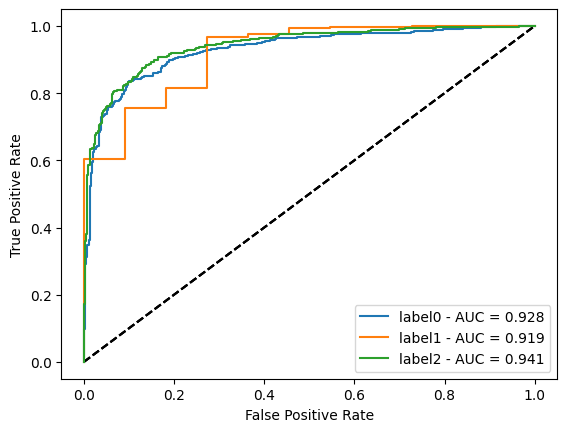

In [ ]:
from utils.visualization_funcs import plot_auc_curve


plot_auc_curve(cfg, CLASS_NAME, y_true, y_prob_pred)

In [ ]:
test_bboxes

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (973,) + inhomogeneous part.

In [57]:
pred_bbx

array([[[0.62370205, 0.8076106 , 0.8364005 , 1.0431113 ],
        [0.49619   , 0.69996464, 0.9688938 , 1.0659215 ],
        [0.62094676, 0.8091512 , 0.91454065, 1.0668626 ]],

       [[0.35351956, 0.29719257, 0.66128075, 0.545484  ],
        [0.40303108, 0.3020723 , 0.60564286, 0.49606118],
        [0.19296776, 0.16918658, 0.27069935, 0.23895755]],

       [[0.35197964, 0.77007294, 0.62535465, 1.0040785 ],
        [0.26738515, 0.7197318 , 0.7843164 , 1.0616685 ],
        [0.40533045, 0.74845284, 0.6681515 , 0.9431779 ]],

       ...,

       [[0.04323847, 0.21697925, 0.5155628 , 0.590506  ],
        [0.01179223, 0.21774398, 0.6769129 , 0.73914623],
        [0.15705067, 0.31715932, 0.5194113 , 0.61310315]],

       [[0.31266388, 0.19846211, 0.613842  , 0.34658825],
        [0.1909553 , 0.15453331, 0.6730404 , 0.4757733 ],
        [0.041132  , 0.0233831 , 0.05926369, 0.02528057]],

       [[0.3133559 , 0.5960481 , 0.54088914, 0.7667756 ],
        [0.20113476, 0.46552277, 0.62792164, 0.75

In [60]:
from src.losses.iou_loss import iou_metric

iou_metric(test_bboxes[0], pred_bbx[0])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.03333966, 0.38420993, 0.04968832], dtype=float32)>

In [66]:
def plot_iou_histogram(y_true_bbox, y_pred_bbox, class_ids):
    """
    Plots a histogram of Intersection over Union (IoU) scores.

    Args:
        y_true_bbox: Ground truth bounding boxes (list of lists or numpy array).
        y_pred_bbox: Predicted bounding boxes (list of lists or numpy array).
        class_ids: list of class ids.
    """
    iou_scores = []
    for i in range(len(y_true_bbox)):
        for j in range(len(class_ids[i])):
            try:
                iou = iou_metric(y_true_bbox[i][j], y_pred_bbox[i][j])
                iou_scores.append(iou)
            except:
                continue
    plt.figure(figsize=(10, 6))
    plt.hist(iou_scores, bins=20, range=(0, 1), edgecolor='black')
    plt.title('IoU Score Distribution')
    plt.xlabel('IoU Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [67]:
test_bboxes[0][1]

array([0.36690647, 0.58333333, 0.85611511, 0.98484848])

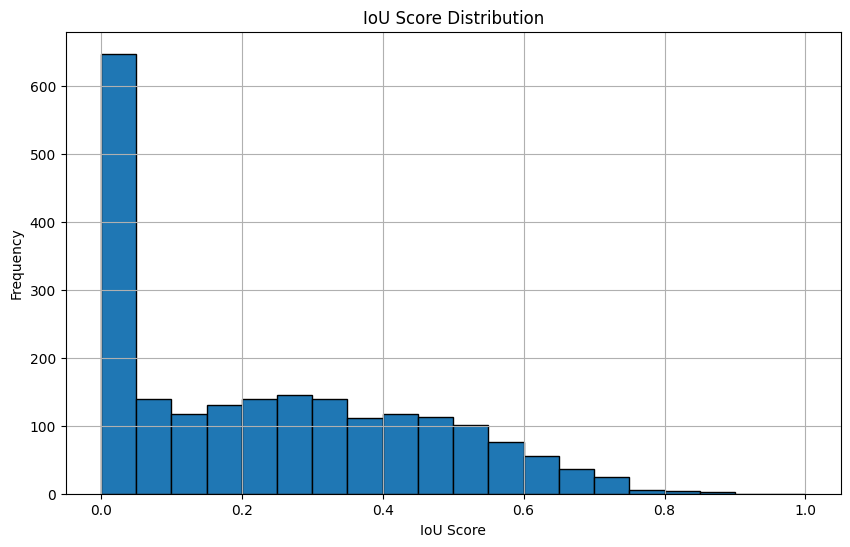

In [68]:
plot_iou_histogram(test_bboxes, pred_bbx, y_true)